# Data Preanalysis for Clustering

This tutorial show how to analyse trajectory data. The aim in this tutorial is, to find repeatingly occuring behaviour in the trajectory. This prototypical behaviour can be obtained by clustering the trajectory data. This idea is inspired by Braun et al.'s paper "Identifying Prototypical Components in Behaviour Using Clustering Algorithms"
If you wish to have more details about the idea, please refer to this paper.


As we use the k-mean algorithm to cluster the the data. This algorithm need can not decide in how many clusters the data should be clustered. Therefore we need to find out the number of clusters k before we can cluster the data.
Since the trajectory data we are dealing with is usually noisy and to make it easier for the clusterer, we prepare the data first to obtain optimal results.

## Steps to be performed
The following steps are performed to obtain the different prototypical behaviours
1. Preprocessing
   * Smoothening of the data, to reduce noise
   * calculate the velocities of data the pure location/rotational data
   * perform pca, to find relevant dimensions
   we treat locational and rotational information seperated here and therefore perform two pcas
   * Rescale the data, so that it is normalized between the values of 0 and 1.
2. Find optimal number of clusters k
   * Calculate the cost for each number of clusters
   * Check, how the costs change when adding another cluster (difference of costs)
   * Use the previous steps to reduce the possible range of clusters
   * within the new cluster range, calculate cluster instability
   * within the new cluster range, calculate cluster quality
   * use all information calculated above to make a decision on k
       

Since the trajectory module of the navipy toolbox, already provides many of the necessary feature,
we first load the data into a trajectory object. Notice that here the data was provided as a csv file.

In [1]:
from navipy.trajectories import Trajectory
import pandas as pd

fname = '/media/luiza/Daten/Repos/tmpnavibox/body_traj/bee_'
headdf=None
for bee in ['05','06','07','08','11','17']:
    filename=fname+bee+'_head_traj.hdf'
    reread = pd.read_hdf(filename)
    if headdf is None:
        headdf=reread
    else:
        headdf = headdf.append(reread, ignore_index=True)

    #print(reread.columns)
trajhead = Trajectory()
trajhead.from_dataframe(headdf)

fname = '/media/luiza/Daten/Repos/tmpnavibox/body_traj/bee_'
bodydf=None
for bee in ['05','06','07','08','11','17']:
    filename=fname+bee+'_body_traj.hdf'
    reread = pd.read_hdf(filename)
    if bodydf is None:
        bodydf=reread
    else:
        bodydf = bodydf.append(reread,ignore_index=True)

    print(reread.columns)
trajbody = Trajectory()
trajbody.from_dataframe(bodydf)

print(len(list(trajbody.index)),len(set(list(trajbody.index))))


MultiIndex(levels=[['location', 'zyx'], ['alpha_0', 'alpha_1', 'alpha_2', 'x', 'y', 'z']],
           labels=[[0, 0, 0, 1, 1, 1], [3, 4, 5, 0, 1, 2]])
MultiIndex(levels=[['location', 'zyx'], ['alpha_0', 'alpha_1', 'alpha_2', 'x', 'y', 'z']],
           labels=[[0, 0, 0, 1, 1, 1], [3, 4, 5, 0, 1, 2]])
MultiIndex(levels=[['location', 'zyx'], ['alpha_0', 'alpha_1', 'alpha_2', 'x', 'y', 'z']],
           labels=[[0, 0, 0, 1, 1, 1], [3, 4, 5, 0, 1, 2]])
MultiIndex(levels=[['location', 'zyx'], ['alpha_0', 'alpha_1', 'alpha_2', 'x', 'y', 'z']],
           labels=[[0, 0, 0, 1, 1, 1], [3, 4, 5, 0, 1, 2]])
MultiIndex(levels=[['location', 'zyx'], ['alpha_0', 'alpha_1', 'alpha_2', 'x', 'y', 'z']],
           labels=[[0, 0, 0, 1, 1, 1], [3, 4, 5, 0, 1, 2]])
MultiIndex(levels=[['location', 'zyx'], ['alpha_0', 'alpha_1', 'alpha_2', 'x', 'y', 'z']],
           labels=[[0, 0, 0, 1, 1, 1], [3, 4, 5, 0, 1, 2]])
32263 32263


As one can see, do we have a lot of Nans now. That is no problem as the preprocessing function handels nans byitself. It uses the Trajectory functions to remove them.

Now the next steps are the preprocessing. This can be done with the preprocessing module of the navipy toolbox, it includes a butterworth filter and a pca transformation.
The function returns a table that contains the processed data.

Note that this function lets you choose on which columns of the trajectory a pca should be applied and to how many components it should be reduced. In default, the locational (x,y,z) and the rotational (alpha, beta, gamma) information are treated independent and no data dimension is performed but only a pca is performed for three components each. So one pca is performed on x,y,z and one on alpha_0, alpha_1, alpha_2

In [2]:
from navipy.preanalysis.preprocessing import preprocessing

X_std, transformed = preprocessing([trajbody,trajhead],lamb=250,components=6,table_index=[[0,1],[0,1]], columns=[[['dx', 'dy', 'dz'], ['dx', 'dy', 'dz']],[['dalpha_0', 'dalpha_1', 'dalpha_2'],['dalpha_0', 'dalpha_1', 'dalpha_2']]])
X_stdnew=pd.concat([X_std[0],X_std[1]],axis=1, sort=False)


In [3]:
#print(len(list(X_stdnew.index)),len(set(list(X_stdnew.index))))
#print(X_stdnew.columns)

X_stdnew2=pd.DataFrame(index=X_stdnew.index,data=X_stdnew.values,columns=['dx_body','dy_body','dz_body',
                                                                          'dx_head','dy_head','dz_head',
                                                                          'dalpha_0_body','dalpha_1_body','dalpha_2_body',
                                                                          'dalpha_0_head','dalpha_1_head','dalpha_2_head'])
#print(X_stdnew2.columns)


#X_stdnew2.to_hdf('preprocessed_all.h5',key='processed')

For the evaluation to find the correct number of clusters, we need the data as an np.array

In [3]:
import numpy as np

newData=np.array(X_stdnew.values)

Next we want to find out in how many clusters would be optimal for our data.
It is the easiest to do this graphically, by plotting to get a feeling for the data.
So first we plot two dimensions of the data, to get an idea of how they are related.
Then we perform hierarchical clustering and increase the number of clusters iteratively to plot them
agains the costs for the corresponding number of clusters.

For better understanding lets plot the data first. Here we use only the first two columns of the trajectory to plot. This might already give us a first impression of the data.

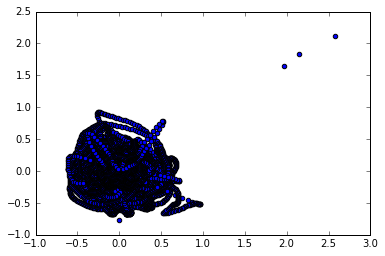

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



plt.scatter(transformed[0].values[:, 0], transformed[0].values[:, 1])
plt.show()

This plot is not very helpful in deciding how many clusters should be used, therefore we will proceed analysis this data.
Next we will to hierarchical clustering with a multiple number of clusters and plot the costs per cluster number

In [25]:
from navipy.preanalysis.preprocessing import get_joining_cost
import scipy.cluster.hierarchy as hac


z = hac.linkage(newData, method='ward')

plt.subplot(121)
dn = hac.dendrogram(z)

plt.subplot(122)
costs, max_nCluster = get_joining_cost(np.array(newData),None)#mytrajart.values[:,0:2]

plt.scatter(range(max_nCluster),costs)

plt.show()

this figure is difficult to read, so lets plot only the first 50 clusters

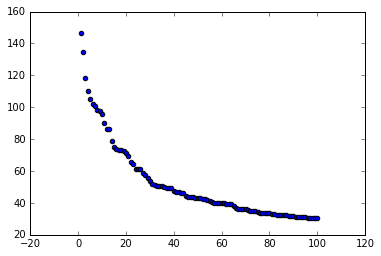

In [26]:
plt.scatter(range(1,101),costs[0:100])
plt.show()

Here we see that the costs start to decrease slower with around 9 clusters. So lets plot the difference of the costs to see, where the costs change only minorly. We do this for the first 20 clusters, as the costs increase again when having more than 20. Here we use the ward joining cost, which describes the costs of joining two clusters, which is calculated with with the clusters variance.

\begin{equation*}
Var_{p+q}=VAR_p+VAR_q+n_pn_q\frac{(x_p-x_q)^2}{n_p+n_q}
\end{equation*}

where VAR_i is the variance of the i-th cluster n_i is the size of that cluster and x_i is the average point of the cluster.

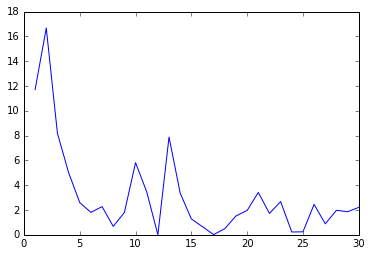

In [27]:
knee = np.abs(np.diff(costs)[0:30])
plt.plot(range(1,31), knee)

plt.show()

Here we see, that if we use less than 5 clusters, the costs increase significantly. Also we can see that we have a minimum in the change of costs for 11 clusters. When increasing to 12 clusters the costs increase again.

With 15 clusters, we have again a very small change of costs, but as we want the smallest amount of clusters with a small change in costs, we should prefer 12 here. Also its keeps everything more simple.

Luckily for us, does the preanalysis module provide a plotting function that includes all of this already

In [14]:
from navipy.preanalysis import plotting as anplt


anplt.plot_Data_costs(newData)

So know we have a hint to go with 12 clusters already. 
To cluster the data the k-mean algorithm is used in the preanalysis module. 
But to be sure we will check for other measurements, as the cluster instability and the cluster quality. 
Luckily the plotting part of the preanalysis module also provides a function for this. 

In [15]:
anplt.plot_instab_qualities(newData, 30)

In the most upper subplot, the instability values are displayed. The middle one shows the cluster quality, and the lowest the average quality over several k-mean trials with different starting conditions.
We have three lines, because we used 3 different datasets. The blue one is the whole data, for the green line randomly 90% of the data was chosen and for the red line 80%.

In the figure for the instability we can see, that the instability starts to increase with 5 clusters for all dataset.
For the quality, one can see that the quality for the different datasets starts to differ a with about 17 clusters.  The quality is stable with less than 17 clusters. However, here the quality is very low, therefore the results are difficult to interpret. That might be because we are only plotting the measurements for up to 30 clusters. We might get a different impression with more clusters.

So far a overall conclusion seems difficult

Of course it is also possible to individually get the different measures for the data. The preanalysis package provides the cluster quality, a mean cluster quality for multiply runs of the k-mean with different starting points and the instability measure.
The quality of a cluster c_i is simply the squared minimum distance from its centroid to the other clusters' centers divided by the variance of the cluster.

\begin{equation*}
q_c = \frac{min_{c!=g} (d_{cg}^2)}{VAR_{c}}
\end{equation*}

The instability measure is the mean average distance between all clusters. For that multiple k-mean runs are performed with different starting points and the set of cluster centers that has the smallest distance to all other sets of cluster centers is computed. This set is going to be the mean set of clusters centers. Then the average distance from this mean set is calculated to all the centroids of the other run. The resulting quantity is our instability measure.

So if one wishes to get the quality measure the quality function of the preanalysis modul.
It allows the user to choose how much of the data should be used and the range of clusters to be considered.
As one could see earlier, might the numbers of clusters change the impression of the figure. Therefore we will plot again every measure with more clusters. Here with up to 50.

In [16]:
from navipy.preanalysis.preprocessing import quality


qual = quality(newData, pro=1, max_nCluster=50, min_nCluster=2)

plt.plot(range(2,50),qual)
qual1 = quality(newData, pro=0.9, max_nCluster=50, min_nCluster=2)

plt.plot(range(2,50),qual1)
qual2 = quality(newData, pro=0.8, max_nCluster=50, min_nCluster=2)

plt.plot(range(2,50),qual2)

The same can be done for the mean quality. Here an example with 10 runs for each number of clusters.

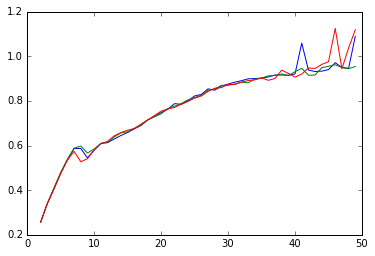

In [17]:
from navipy.preanalysis.preprocessing import meanQuality


meanqual = meanQuality(newData, pro=1, max_nCluster=50, min_nCluster=2, numsets=10)
plt.plot(range(2,50),meanqual)

meanqual2 = meanQuality(newData, pro=0.9, max_nCluster=50, min_nCluster=2, numsets=10)
plt.plot(range(2,50),meanqual2)

meanqual3 = meanQuality(newData, pro=0.8, max_nCluster=50, min_nCluster=2, numsets=10)
plt.plot(range(2,50),meanqual3)

and the instability

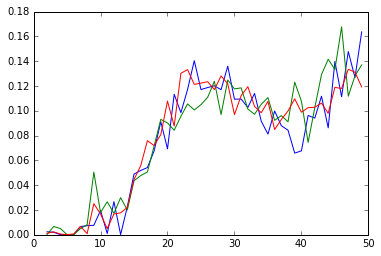

In [18]:
from navipy.preanalysis.preprocessing import instab
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


instab1 = instab(newData, pro=1, max_nCluster=50, min_nCluster=2, numsets=10)
plt.plot(range(2,50),instab1)

instab2 = instab(newData, pro=0.9, max_nCluster=50, min_nCluster=2, numsets=10)
plt.plot(range(2,50),instab2)

instab3 = instab(newData, pro=0.8, max_nCluster=50, min_nCluster=2, numsets=10)
plt.plot(range(2,50),instab3)

Now that we know we should use 11 clusters, we need to do the actual clustering. We use the k mean implementation of sklearn.
Also we prepare the color dataframe to color be able to color all points that belong to one cluster in the same color

In [4]:
from sklearn.cluster import KMeans
import pandas as pd


kmeans = KMeans(n_clusters=12).fit(newData)
labels = kmeans.predict(newData)



rgba_vals=[[0,0,0,1], [0,0,1,1],[0,1,0,1],[0,1,1,1],[1,0,0,1],
           [1,0,1,1],[1,1,0,1],[1,1,1,1],[1,0.5,0,1],[0.5,0,1,1],
           [0.5,0.5,0,1],[1,1,0.5,1]]
label2color=pd.DataFrame(data=rgba_vals,columns=['r','g','b','a'])
label2color.to_hdf('labels2color.h5',key='colors')

colors = pd.DataFrame(columns=['r','g','b','a'])
for i,l in enumerate(labels):
    colors.loc[X_stdnew.index[i]]=rgba_vals[l]

colors.to_hdf('colors.h5',key='colors')



/home/luiza/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:1993: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block0_values] [items->['r', 'g', 'b', 'a']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [6]:
tmpdata=np.column_stack([newData,labels])
tmpcolumns = np.append(X_stdnew2.columns,['labels'])

X_std_labels=pd.DataFrame(index=X_stdnew.index, data=tmpdata,columns=tmpcolumns)
X_std_labels.to_hdf('preprocessed_labels.h5',key='labels')

get the filtered velocity and angular velocity of the head and body that was not transformed by the pca.
Also put the color codes into a pandas dataframe


In [7]:
newbody=transformed[0].loc[colors.index]
newhead=transformed[1].loc[colors.index]

#colors = pd.DataFrame(data=colors.values,columns=['r','g','b','a'])

rename the columns so they head and body values can be combined into one dataframe. newtraj will contain the filtered velocity and angular velocity of head and body

In [8]:
newhead=newhead.rename(columns={'dx': 'dx_head', 'dy' : 'dy_head', 'dz' : 'dz_head',
                                   'dalpha_0' : 'dalpha_0_head','dalpha_1' : 'dalpha_1_head',
                                   'dalpha_2' : 'dalpha_2_head'})
newbody=newbody.rename(columns={'dx': 'dx_body', 'dy' : 'dy_body', 'dz' : 'dz_body',
                                   'dalpha_0' : 'dalpha_0_body','dalpha_1' : 'dalpha_1_body',
                                   'dalpha_2' : 'dalpha_2_body'})
newtraj=pd.concat([newbody,newhead],axis=1)
newtraj=newtraj.loc[X_stdnew.index]
newtraj.to_hdf('filtered_velocity.h5',key='velocity')

rename and concatinate the filtered original data (x,y,z, yaw, pitch, roll) of head and body, to have one frame

In [9]:
trajbody,trajhead
newheadtraj=trajhead.rename(columns={'x': 'x_head', 'y' : 'y_head', 'z' : 'z_head',
                                   'alpha_0' : 'alpha_0_head','alpha_1' : 'alpha_1_head',
                                   'alpha_2' : 'alpha_2_head'})
newbodytraj=trajbody.rename(columns={'x': 'x_body', 'y' : 'y_body', 'z' : 'z_body',
                                   'alpha_0' : 'alpha_0_body','alpha_1' : 'alpha_1_body',
                                   'alpha_2' : 'alpha_2_body'})
newtrajorig=pd.concat([newbodytraj.loc[X_stdnew.index],newheadtraj.loc[X_stdnew.index]],axis=1)
newtrajorig.to_hdf('filtered_traj.h5', key='filtered')
#print(newtrajorig.loc[1446])
#tmpdata=newtrajorig.loc[X_std.index]

/home/luiza/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:1993: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block1_values] [items->[('location', 'x_body'), ('location', 'y_body'), ('location', 'z_body'), ('location', 'x_head'), ('location', 'y_head'), ('location', 'z_head')]]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Figure from the paper for some reason the index is odd but I do not know why

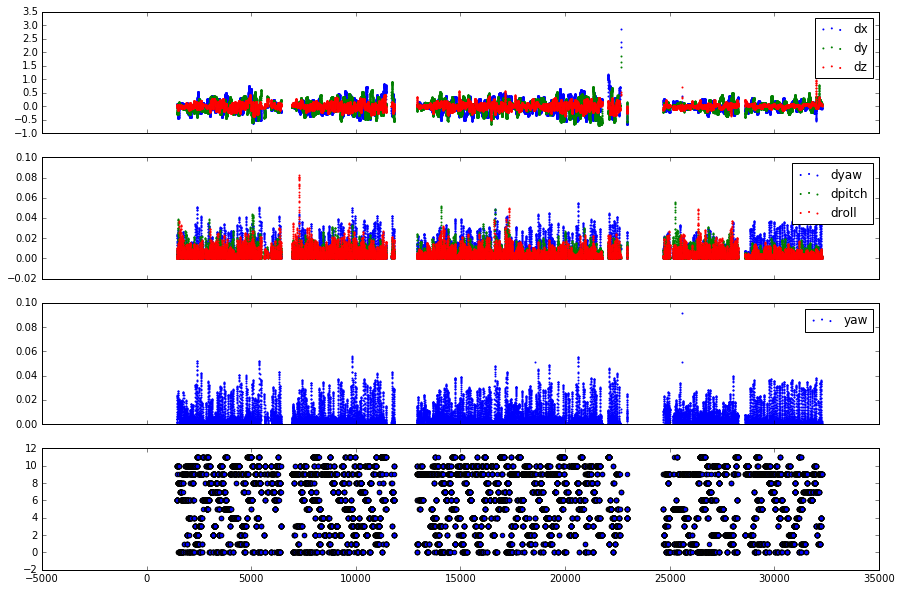

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

new_vel = newtraj
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,10), sharex=True)
print(ax)
ax[0].scatter(new_vel.index, new_vel['dx_head'],color='b',s=1)
ax[0].scatter(new_vel.index, new_vel['dy_head'],color='g',s=1)
ax[0].scatter(new_vel.index, new_vel['dz_head'],color='r',s=1)
ax[0].legend(['dx','dy','dz'])

ax[1].scatter(new_vel.index, abs(new_vel['dalpha_2_head']),color='b',s=1)
ax[1].scatter(new_vel.index, abs(new_vel['dalpha_1_head']),color='g',s=1)
ax[1].scatter(new_vel.index, abs(new_vel['dalpha_0_head']),color='r',s=1)
ax[1].legend(['dyaw','dpitch','droll'])

tmpdata=abs(np.diff(np.unwrap(newtrajorig[('zyx','alpha_0_head')])))

ax[2].scatter(new_vel.index[1::], tmpdata ,color='b',s=1)
ax[2].set_ylim([0,0.1])
#ax[2].scatter(mytraj.index, mytraj[('zyx','alpha_1')].diff(),color='g',s=1)
#ax[2].scatter(mytraj.index, mytraj[('zyx','alpha_2')].diff(),color='r',s=1)
ax[2].legend(['yaw'])#,'pitch','roll'])


ax[3].scatter(new_vel.index, labels)

Boxplots

4


/home/luiza/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0 [0] [0]
1 [0] [1]
2 [0] [2]
3 [1] [0]
4 [1] [1]
5 [1] [2]
6 [2] [0]
7 [2] [1]
8 [2] [2]
9 [3] [0]
10 [3] [1]
11 [3] [2]


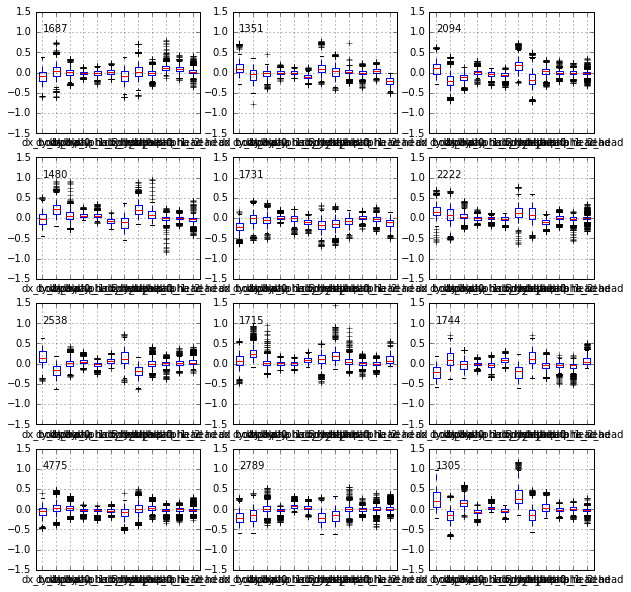

In [11]:
nrows = len(np.unique(labels))//3
if (len(np.unique(labels))/3 - nrows)!=0:
    nrows+=1
scale = 10
fig, ax = plt.subplots(nrows=nrows, ncols=3,figsize=(10,10))
print(nrows)
for l in set(labels):
    tmpind = np.where(labels==l)[0]
    ax[l%nrows][l//4].set_ylim([-1.5,1.5])
    #ax[l%nrows][l//4].set_xlim([-10,10])
    tmpdf = new_vel.iloc[tmpind]
    tmpdf.dalpha_0_head*=scale
    tmpdf.dalpha_1_head*=scale
    tmpdf.dalpha_2_head*=scale
    tmpdf.dalpha_0_body*=scale
    tmpdf.dalpha_1_body*=scale
    tmpdf.dalpha_2_body*=scale
    print(l,[l//3],[l%3])
    tmpdf.boxplot(ax=ax[l//3][l%3])
    ax[l//3][l%3].text(1,1,str(len(tmpind)))

compute the median for x,y,z, yaw, pitch, roll for every cluster for further analysis

In [22]:
from sklearn.preprocessing import MinMaxScaler

###which scaling??? -median/std or -min/(max-min)
median=newtraj.loc[X_stdnew.index]#.copy().append(pd.DataFrame(index=X_stdnew.index,data=labels,columns=['labels']))
print(len(list(median.index)))
print(len(labels))
median['labels']=labels
#median=median.dropna()
#median=median.groupby(['labels']).mean()
median=median.groupby(['labels']).mean()
#print(median.head())
scaled_vals=median.values.copy()
maxi=np.max(median.values,axis=0)

mini=np.min(median.values,axis=0)
#print(mini)
for i in range(len(median.columns)):
    indpos=np.where(median.values[:,i]>=0)[0]
    scaled_vals[indpos,i]=scaled_vals[indpos,i]/maxi[i]
    indneg=np.where(median.values[:,i]<0)[0]
    scaled_vals[indneg,i]=-scaled_vals[indneg,i]/mini[i]
median_std=pd.DataFrame(index=median.index,data=scaled_vals,columns=median.columns)
#print(median_std.head())

#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler.fit(median.values)
#newmedians=scaler.transform(median.values)
#median_std=pd.DataFrame(data=newmedians,columns=median.columns, index=median.index)
#print(median_std.head())





25431
25431
         dx_body   dy_body   dz_body  dalpha_0_body  dalpha_1_body  \
labels                                                               
0      -0.101967  0.044780  0.005741      -0.000659      -0.001238   
1       0.115727 -0.051872 -0.022780       0.000117      -0.000238   
2       0.110947 -0.205879 -0.114511       0.001462      -0.004223   
3      -0.020781  0.236602  0.067817       0.006450       0.006937   
4      -0.214443 -0.017887 -0.048030       0.001687      -0.001588   

        dalpha_2_body   dx_head   dy_head   dz_head  dalpha_0_head  \
labels                                                               
0            0.001673 -0.093454  0.034329 -0.001759       0.011866   
1           -0.010520  0.109520  0.026905  0.016273      -0.001049   
2           -0.006354  0.178393 -0.172034  0.016471      -0.000009   
3           -0.007184 -0.116925  0.224761  0.091689      -0.000824   
4           -0.010077 -0.174189 -0.141000 -0.074836       0.000793   

      

head movement prototypes the three first arrows indicate yaw, pitch and roll. the fourth one with three arrows represent dx,dy,dz. The one to the right (or left for negative) is dx, the one to the top (or button for negative) id dy. and the diagonal one is dz

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


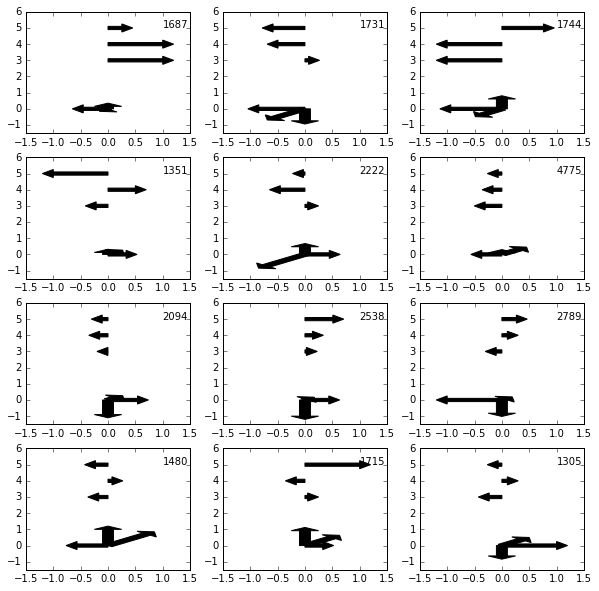

In [23]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math


nrows = len(np.unique(labels))//3
print(set(labels))
if (len(np.unique(labels))/3 - nrows)!=0:
    nrows+=1
scale = 10
fig, ax = plt.subplots(nrows=nrows, ncols=3,figsize=(10,10))
for l in set(labels):
    tmpind=np.where(labels==l)[0]
    ax[l%nrows][l//4].set_ylim([-1.5,6])
    ax[l%nrows][l//4].set_xlim([-1.5,1.5])
    ax[l%nrows][l//4].arrow(0, 0,median_std['dx_head'][l],0,width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 0,0,median_std['dy_head'][l],width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 0,median_std['dz_head'][l]/math.sqrt(2),median_std['dz_head'][l]/math.sqrt(2),width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 5,median_std['dalpha_2_head'][l],0,width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 4,median_std['dalpha_1_head'][l],0,width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 3,median_std['dalpha_0_head'][l],0,width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].text(1, 5,str(len(tmpind)))

Body movement prototypes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


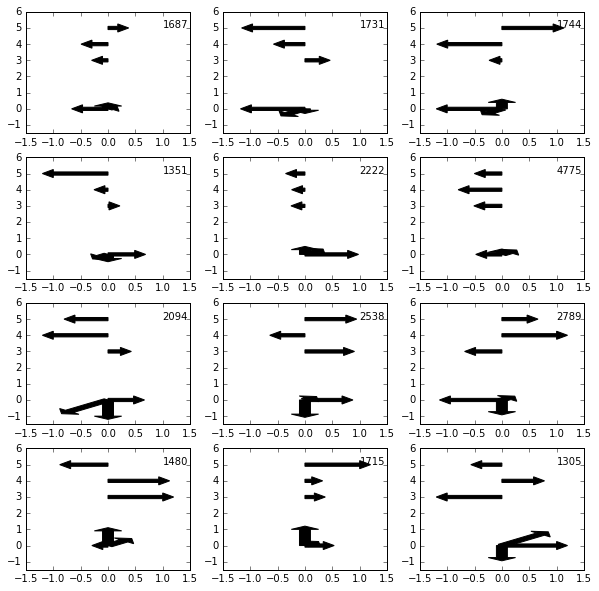

In [24]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math


nrows = len(np.unique(labels))//3
print(set(labels))
if (len(np.unique(labels))/3 - nrows)!=0:
    nrows+=1
scale = 10
fig, ax = plt.subplots(nrows=nrows, ncols=3,figsize=(10,10))
for l in set(labels):
    tmpind=np.where(labels==l)[0]
    ax[l%nrows][l//4].set_ylim([-1.5,6])
    ax[l%nrows][l//4].set_xlim([-1.5,1.5])
    ax[l%nrows][l//4].arrow(0, 0,median_std['dx_body'][l],0,width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 0,0,median_std['dy_body'][l],width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 0,median_std['dz_body'][l]/math.sqrt(2),median_std['dz_body'][l]/math.sqrt(2),width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 5,median_std['dalpha_2_body'][l],0,width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 4,median_std['dalpha_1_body'][l],0,width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].arrow(0, 3,median_std['dalpha_0_body'][l],0,width=0.2,head_width=0.5, head_length=0.2, fc='k', ec='k')
    ax[l%nrows][l//4].text(1, 5,str(len(tmpind)))